In [90]:
# Ut = λ(A)U − ω(A)V + D1∇2U
# Vt = ω(A)U + λ(A)V + D2∇2V
# A2 = U2 + V2 
# ∇2 = ∂2x + ∂2y

import numpy as np
from scipy.integrate import solve_ivp
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt

n = 64
beta = 1
D1, D2 = 0.1, 0.1
m = 1 # Number of spirals
tspan = np.arange(0, 4.5, 0.5)

T = 4
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx*ny

# Spatial domain & initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
# w = np.exp(-X**2 - Y**2 / 20).flatten()  # Initialize as complex "+ 1j * np.zeros((nx, ny))"
tspan = np.arange(0, 4.5, 0.5)

# Spectral & Initial Conditions
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
#kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
#ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


# Compute u and v
radius = np.sqrt(X**2 + Y**2) 
angle = np.angle(X + 1j * Y) 

u = np.tanh(radius) * np.cos(m * angle - radius)
v = np.tanh(radius) * np.sin(m * angle - radius)

ut = fft2(u)
vt = fft2(v)

uv_stack = np.hstack([(ut.reshape(N)), (vt.reshape(N))])

def lambdaFunc(A):
    return 1 - A

def omegaFunc(A, beta):
    return -beta * A



In [92]:
def spectral_rhs(t, uv_stack):
    utc = uv_stack[0:N]
    ut = utc.reshape((nx, ny))
    u = ifft2(ut)
    
    vtc = uv_stack[N:]
    vt = utc.reshape((nx, ny))
    v = ifft2(vt)

    A_2 = u*u + v*v

    lambda_A = lambdaFunc(A_2)
    omega_A = omegaFunc(A_2, beta)

    u_t = (-D1 * K * ut + fft2(lambda_A * u - omega_A * v)).reshape(N) 
    v_t = (-D2 * K * vt + fft2(omega_A * u + lambda_A * v)).reshape(N) 
    rhs = np.hstack([(u_t), (v_t)])
    
    return rhs

spectral_rhs(tspan, uv_stack)

array([ 24.94003847+1.72563323e-31j, -18.37351669-5.75922324e+01j,
       -15.41402646+3.15319861e+01j, ...,  42.98153971+7.62868152e+02j,
        87.69743584-6.35884696e+02j,  68.22874498-3.70072317e+02j])

In [86]:
uvtsol = solve_ivp(spectral_rhs, [0, T], uv_stack, t_eval=tspan, args=(), method='RK45')

z = uvtsol.y
A1 = z
print(A1)

[[ 2.49400385e+01+0.00000000e+00j  4.11191719e+01-1.98674200e-30j
   6.77940537e+01-1.57443648e-30j ...  5.00934152e+02+1.57974218e-26j
   8.25900804e+02+1.74259337e-26j  1.36168021e+03+3.70830111e-26j]
 [-1.85566636e+01-5.81663109e+01j -3.04441588e+01-9.54279521e+01j
  -4.99468455e+01-1.56559595e+02j ... -3.61846578e+02-1.13421685e+03j
  -5.93647385e+02-1.86080209e+03j -9.73940980e+02-3.05284156e+03j]
 [-1.60475587e+01+3.28279829e+01j -2.59408131e+01+5.30663003e+01j
  -4.19332185e+01+8.57814580e+01j ... -2.86323308e+02+5.85722530e+02j
  -4.62840463e+02+9.46818088e+02j -7.48179714e+02+1.53052756e+03j]
 ...
 [ 2.47302147e+01-5.66774723e+02j  1.02838211e+02+3.89347572e+02j
   4.69746066e+02+4.46119851e+03j ...  9.89160584e+04+1.17303170e+06j
   3.56124060e+05+4.41496604e+06j  1.27250173e+06+1.66150439e+07j]
 [ 2.53372012e+01-3.61633792e+02j  1.52453730e+02-1.19901716e+03j
   7.20199970e+02-5.03690581e+03j ...  1.72748205e+05-1.37273027e+06j
   6.60826033e+05-5.42578751e+06j  2.53592340e+

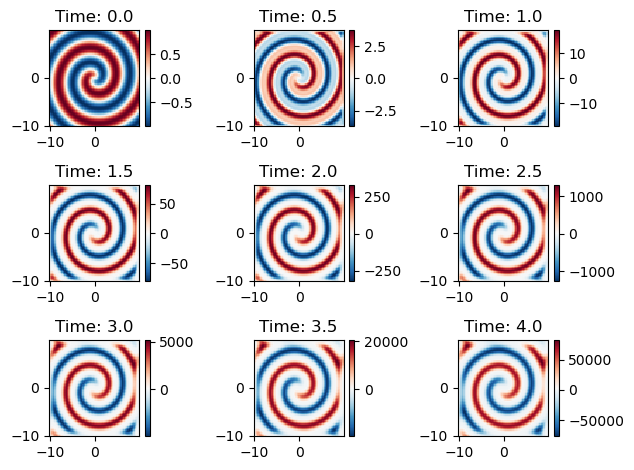

In [88]:
for j,t in enumerate(tspan):
    a = np.real(ifft2(z[N:, j].reshape((nx, ny))))
    plt.subplot(3,3, j+1)
    plt.pcolor(x, y, a, cmap = 'RdBu_r')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = arange(0,N+1)
		x = cos(pi*n/N).reshape(N+1,1) 
		c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = tile(x,(1,N+1))
		dX = X - X.T
		D = dot(c,1./c.T)/(dX+eye(N+1))
		D -= diag(sum(D.T,axis=0))
	return D, x.reshape(N+1)
    
N = 40
D, x = cheb(N)

D[N, :] = 0 # Nth row  = 0
D[0, :] = 0 # 0th row = 0

D_xx = np.dot(D, D) / (10**2)
y = x

N2 = (N+1) * (N+1)